# **Propulsion Plants Decay Evaluation**

---
A propulsion system is a machine that produces thrust to push an object forward. A system which provides thrust to propel the ship.

Maintenance costs of a propulsion system represent a large slice of total operational expenses. Depending on the adopted strategy, impact of maintenance on overall expenses can remarkably vary; for example, letting an asset running up until breakdown can lead to unaffordable costs.

Maintenance includes all actions necessary to retain a system or an item in, or restoring it to, a state in which it can perform its required functions. The most common way of inflecting such concepts in practice has been always deployed according to a "fix it when it breaks" approach. However, this has been becoming an unaffordable and gold-brick methodology since data gathering from the field is ever cheaper and costs related to a breakdown may overcome the asset value.

In particular, maintenance can be of three types:

1.   Corrective maintenance
> In corrective maintenance (CM), the equipment or asset is run down to its breaking down point, and maintenance activities are carried out afterward with the purpose of restoring the system at earliest.


2.   Preventive maintenance
> Preventive maintenance (PM), instead, is carried out before breakdowns in order to avoid them and minimize the possibility of potential issues related to failures.


3.   Condition-based maintenance
>  CBM enables a just-in-time deployment of ship maintenance, by allowing to plan and execute maintenance activities only when needed.


In particular, we take into consideration an application of condition-based maintenance to gas turbines used for vessel propulsion, where the performance and advantages of exploiting statistical/machine learning method(s) in modeling the degradation of the propulsion plant over time are tested.

## **Description of dataset**

I assumed that the dataset on which i will trained the model have been developed and fine tuned over the year on several similar real propulsion plants(Gas Turbine propultion plant).

From this dataset it is also possible to take into account the performance decay over time of the GT components such as GT compressor and turbines.

In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score

import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.chdir("/content/drive/MyDrive/Mechademy")

In [3]:
df = pd.read_csv("propulsion.csv",index_col=0)

In [4]:
df.head()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
0,9.300,27.0,72762.205,3560.393,9753.812,644.806,644.806,1086.583,288.0,780.304,4.523,0.998,22.879,1.050,90.435,1.790,0.973,0.978
1,6.175,18.0,29760.552,2306.825,8780.012,246.011,246.011,776.921,288.0,665.511,2.518,0.998,13.438,1.030,34.596,0.685,0.995,0.975
2,3.144,9.0,8375.774,1386.739,7051.621,60.318,60.318,589.764,288.0,580.587,1.392,0.998,7.566,1.020,12.477,0.247,0.980,0.978
3,3.144,9.0,8377.589,1386.748,7098.469,60.339,60.339,570.651,288.0,576.565,1.390,0.998,7.409,1.021,11.678,0.231,0.984,1.000
4,6.175,18.0,29761.091,2306.825,8782.024,246.021,246.021,769.855,288.0,663.682,2.518,0.998,13.374,1.031,34.154,0.676,0.998,0.980


In [5]:
df.shape

(10000, 18)

**Dataset** is consist of 18 features: 
1. Lever position $lp$
2. Ship speed $v$
3. Gas turbine shaft torque $GTT$
4. Gas turbine rate of revolutions $GTn$
5. Gas generator rate of revolutions $GGn$
6. Starboard propeller torque $Ts$
7. Port propeller torque $Tp$
8. HP turbine exit temperature $T48$
9. GT compressor inlet air temperature $T1$
10. GT compressor outlet air temperature $T2$
11. HP turbine exit pressure $P48$
12. GT compressor inlet air pressure $P1$
13. GT compressor outlet air pressure $P2$
14. GT exhaust gas pressure $Pexh$
15. Turbine injection control $TIC$
16. Fuel flow $mf$
17. GT Compressor decay state coefficient.
18. GT Turbine decay state coefficient.

**Goal**
>The purpose of the analysis is to train a model on 16 listed measures $ \{ lp, v, GTT, GTn, GGn, Ts, Tp, T48, T1, T2, P48, P1, P2, Pexh, TIC, mf \}$, in order to estimate **GT Compressor decay state coefficient** and **GT Turbine decay state coefficient** from them.




## **Data Cleaning and Preprocessing**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lever position (lp) [ ]                        10000 non-null  float64
 1   Ship speed (v) [knots]                         10000 non-null  float64
 2   Gas Turbine shaft torque (GTT) [kN m]          10000 non-null  float64
 3   Gas Turbine rate of revolutions (GTn) [rpm]    10000 non-null  float64
 4   Gas Generator rate of revolutions (GGn) [rpm]  10000 non-null  float64
 5   Starboard Propeller Torque (Ts) [kN]           10000 non-null  float64
 6   Port Propeller Torque (Tp) [kN]                10000 non-null  float64
 7   HP Turbine exit temperature (T48) [C]          10000 non-null  float64
 8   GT Compressor inlet air temperature (T1) [C]   10000 non-null  float64
 9   GT Compressor outlet air temperature (T2) [C]  1000

The data is clean with no missing values.

In [7]:
df.nunique()      #T1 and P1 contain constant number

Lever position (lp) [ ]                             9
Ship speed (v) [knots]                              9
Gas Turbine shaft torque (GTT) [kN m]            9634
Gas Turbine rate of revolutions (GTn) [rpm]      3422
Gas Generator rate of revolutions (GGn) [rpm]    9926
Starboard Propeller Torque (Ts) [kN]             3880
Port Propeller Torque (Tp) [kN]                  3880
HP Turbine exit temperature (T48) [C]            9890
GT Compressor inlet air temperature (T1) [C]        1
GT Compressor outlet air temperature (T2) [C]    9694
HP Turbine exit pressure (P48) [bar]              523
GT Compressor inlet air pressure (P1) [bar]         1
GT Compressor outlet air pressure (P2) [bar]     4000
Gas Turbine exhaust gas pressure (Pexh) [bar]      19
Turbine Injecton Control (TIC) [%]               7403
Fuel flow (mf) [kg/s]                             694
GT Compressor decay state coefficient.             51
GT Turbine decay state coefficient.                26
dtype: int64

From the above info target columns contain 51 and 26 diffrent values. So from this point of view this can be seen as either a regression or classification problem.
I will use regression method for this case.

In [8]:
df.describe()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.150075,14.951400,27100.647714,2131.151788,8194.182366,225.957785,225.957785,734.476178,288.0,645.748980,2.345732,9.980000e-01,12.262597,1.029402,33.480715,0.659100,0.975021,0.987455
std,2.624015,7.740467,22062.780307,772.211732,1090.569425,199.737886,199.737886,173.009157,0.0,72.483036,1.081038,2.236101e-13,5.320817,0.010353,25.721725,0.504791,0.014734,0.007510
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,444.731000,288.0,540.999000,1.093000,9.980000e-01,5.828000,1.019000,0.000000,0.068000,0.950000,0.975000
25%,3.144000,9.000000,8375.791500,1386.758000,7056.520500,60.317000,60.317000,589.841000,288.0,577.980750,1.389000,9.980000e-01,7.445000,1.020000,13.534000,0.246000,0.962000,0.981000
50%,5.140000,15.000000,21630.133500,1924.325000,8480.527000,175.264000,175.264000,705.351000,288.0,636.800000,2.082000,9.980000e-01,11.086000,1.026000,25.249500,0.496000,0.975000,0.987000
75%,7.148000,21.000000,39000.710250,2678.078000,9132.132500,332.360000,332.360000,833.154750,288.0,693.656750,2.981000,9.980000e-01,15.649000,1.036000,44.500000,0.881000,0.988000,0.994000
max,9.300000,27.000000,72783.338000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,288.0,789.094000,4.560000,9.980000e-01,23.140000,1.052000,92.556000,1.832000,1.000000,1.000000


**OBSERVATION**

* Maximum speed of ship is 27 knot while minimum is 3 knot
* GT Compressor Inlet Air Temperature $T1$ and GT Compressor Inlet Air Pressure $P1$ have zero-variances.
* Standard deviation of a data set is zero if and only if all of its values are identical. This means they are constant numbers(also pointed above while finding number of uniques).
* $T1$ and $P1$ will be removed from the data.


In [9]:
df.drop(['GT Compressor inlet air temperature (T1) [C]','GT Compressor inlet air pressure (P1) [bar]'],axis=1,inplace=True)


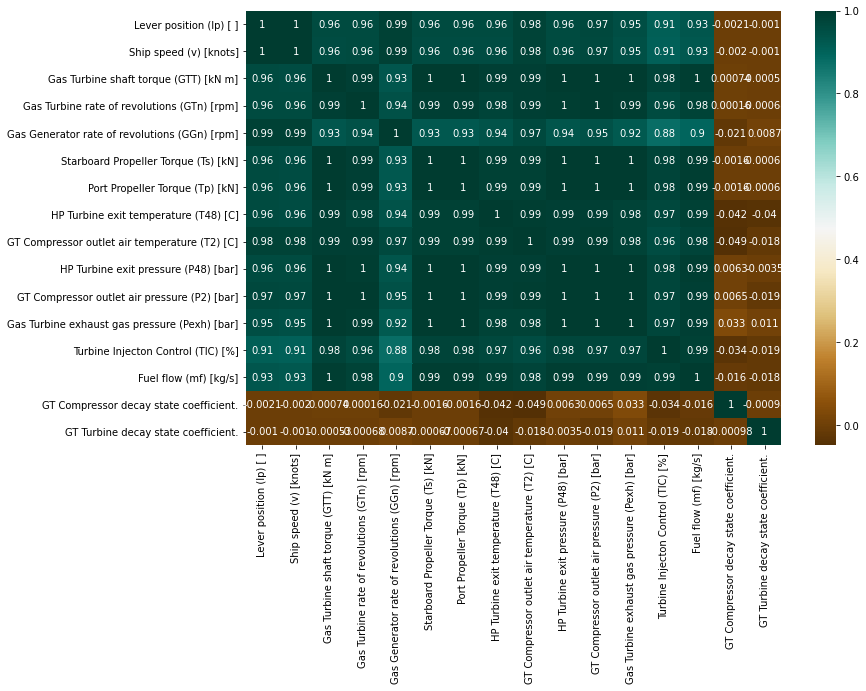

In [10]:
plt.figure(figsize=(12,8))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

As the heatmap shows nearly all of the features are highly corelated to each other, i checked the accuracy by droping some corelated features but it does not give that much good result. So i decide to not drop any other features. 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lever position (lp) [ ]                        10000 non-null  float64
 1   Ship speed (v) [knots]                         10000 non-null  float64
 2   Gas Turbine shaft torque (GTT) [kN m]          10000 non-null  float64
 3   Gas Turbine rate of revolutions (GTn) [rpm]    10000 non-null  float64
 4   Gas Generator rate of revolutions (GGn) [rpm]  10000 non-null  float64
 5   Starboard Propeller Torque (Ts) [kN]           10000 non-null  float64
 6   Port Propeller Torque (Tp) [kN]                10000 non-null  float64
 7   HP Turbine exit temperature (T48) [C]          10000 non-null  float64
 8   GT Compressor outlet air temperature (T2) [C]  10000 non-null  float64
 9   HP Turbine exit pressure (P48) [bar]           1000

## **Train Models**
**Split Data to Training and Test sets**


* 80% of instances used to fit the models.
* The remains of instances (20%) will be used to compute the accuracy scores of models to avoid overfitting.



In [12]:
X=df.iloc[:,0:14]
y1=df.iloc[:,14]
y2=df.iloc[:,15]
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X,y1,y2,test_size=0.2,random_state=13)

In [13]:
print('X shape =',X.shape)
print('X_train shape =',X_train.shape)
print('X_test shape =',X_test.shape)
print('y1_train shape =',y1_train.shape)
print('y1_test shape =',y1_test.shape)
print('y2_train shape =',y2_train.shape)
print('y2_test shape =',y2_test.shape)

X shape = (10000, 14)
X_train shape = (8000, 14)
X_test shape = (2000, 14)
y1_train shape = (8000,)
y1_test shape = (2000,)
y2_train shape = (8000,)
y2_test shape = (2000,)


#### **Train the models to predict y1(GT Compressor decay state coefficient.)**




In [14]:
names =[]
MSE =[]
R2 = []
RMSE =[]
MAE = []

models = []
models.append(('Linear regression', LinearRegression()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Bagging Regressor', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))

for name, model in models:

    model.fit(X_train, y1_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(predictions, y1_test)
    mse = mean_squared_error(predictions, y1_test)
    rmse = np.sqrt(mse)
    r2= r2_score(predictions, y1_test)

    names.append(name)
    MSE.append(mse)
    R2.append(r2)
    RMSE.append(rmse)
    MAE.append(mae)

In [15]:
df1=pd.DataFrame({'Model':names,'Mean Absolute Error':MAE, 'Mean Squared Error':MSE,'Root Mean Squared  Error':RMSE, 'R-squared ':R2})
df1

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-squared
0,Linear regression,0.004425,3.198095e-05,0.005655,0.821316
1,Decision Tree,0.001061,2.766130e-06,0.001663,0.987046
2,Bagging Regressor,0.000687,1.540470e-06,0.001241,0.992636
3,RandomForest,0.000571,1.149733e-06,0.001072,0.994486
4,ExtraTreesRegressor,0.000383,5.833564e-07,0.000764,0.997231


The R-squared of Linear Regression Model is about 0.821, and far less than R-squared of others which are all above 0.98.

### **Train the models to predict y2(GT Turbine decay state coefficient.)**



In [16]:
names_1 =[]
MSE_1 =[]
R2_1 = []
RMSE_1 =[]
MAE_1 = []

models = []
models.append(('Linear regression', LinearRegression()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Bagging Regressor', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))

for name, model in models:

    model.fit(X_train, y2_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(predictions, y2_test)
    mse = mean_squared_error(predictions, y2_test)
    rmse = np.sqrt(mse)
    r2= r2_score(predictions, y2_test)

    names_1.append(name)
    MSE_1.append(mse)
    R2_1.append(r2)
    RMSE_1.append(rmse)
    MAE_1.append(mae)

In [17]:
df2=pd.DataFrame({'Model':names,'Mean Absolute Error':MAE_1, 'Mean Squared Error':MSE_1,'Root Mean Squared  Error':RMSE_1, 'R-squared':R2_1})
df2

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-squared
0,Linear regression,0.001652,4.782565e-06,0.002187,0.904931
1,Decision Tree,0.000607,1.868213e-06,0.001367,0.966272
2,Bagging Regressor,0.000465,8.507997e-07,0.000922,0.984008
3,RandomForest,0.000408,7.597561e-07,0.000872,0.985673
4,ExtraTreesRegressor,0.000258,4.207292e-07,0.000649,0.992183


The R-squared of Linear Regression Model is above 0.9, but far less than R-squared of others which are all above 0.98.